In [1]:
pip install comet_ml

Note: you may need to restart the kernel to use updated packages.


In [3]:
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

experiment = Experiment(
  api_key="FTvB3XjNTkSysDFLQnUSqJq1b",
  project_name="pagina-e-commerce",
  workspace="mikelcerio"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mikelcerio/pagina-e-commerce/d0641ee1b6b7409db601da6c500266b4



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans
import shap
import warnings


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import os
import sys

# Añadir la carpeta `src` al path
sys.path.insert(0, os.path.abspath('../src'))

# Importar los módulos necesarios
from data_processing import split_and_save_data
from training import train_and_save_models
from evaluation import evaluate_model

In [3]:
# Cargar los datos procesados
data = pd.read_csv("../data/processed/clientes_preprocesados.csv")
features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
X = data[features]
y = data['Revenue']

In [4]:
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [5]:
# ## 3.2 Entrenamiento de Modelos

# %%
# Función para evaluar y mostrar resultados
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

In [6]:
# %%
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")


Random Forest Evaluation:
Accuracy: 0.91
ROC-AUC Score: 0.91
Precision: 0.90
Recall: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2062
           1       0.90      0.93      0.92      2107

    accuracy                           0.91      4169
   macro avg       0.92      0.91      0.91      4169
weighted avg       0.92      0.91      0.91      4169



In [7]:
# %%
# LightGBM
lgbm = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train, y_train)
evaluate_model(lgbm, X_test, y_test, "LightGBM")

[LightGBM] [Info] Number of positive: 8315, number of negative: 8360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 16675, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM Evaluation:
Accuracy: 0.90
ROC-AUC Score: 0.90
Precision: 0.90
Recall: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2062
           1       0.90      0.91      0.90      2107

    accuracy                           0.90      4169
   macro avg       0.90      0.90      0.90      4169
weighted avg       0.90      0.90      0.90      4169



In [8]:
# XGBoost
xgb_model = xgb.XGBClassifier(scale_pos_weight=1, random_state=42)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


XGBoost Evaluation:
Accuracy: 0.92
ROC-AUC Score: 0.92
Precision: 0.91
Recall: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2062
           1       0.91      0.92      0.92      2107

    accuracy                           0.92      4169
   macro avg       0.92      0.92      0.92      4169
weighted avg       0.92      0.92      0.92      4169



In [9]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
evaluate_model(gb, X_test, y_test, "Gradient Boosting")



Gradient Boosting Evaluation:
Accuracy: 0.88
ROC-AUC Score: 0.88
Precision: 0.89
Recall: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2062
           1       0.89      0.87      0.88      2107

    accuracy                           0.88      4169
   macro avg       0.88      0.88      0.88      4169
weighted avg       0.88      0.88      0.88      4169



In [10]:
# SVM
svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train, y_train)
evaluate_model(svm, X_test, y_test, "SVM")


SVM Evaluation:
Accuracy: 0.83
ROC-AUC Score: 0.83
Precision: 0.87
Recall: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2062
           1       0.87      0.79      0.83      2107

    accuracy                           0.83      4169
   macro avg       0.84      0.83      0.83      4169
weighted avg       0.84      0.83      0.83      4169



In [11]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb_model),
    ('gb', gb),
    ('svm', svm)
], voting='soft')
voting_clf.fit(X_train, y_train)
evaluate_model(voting_clf, X_test, y_test, "Voting Classifier")


[LightGBM] [Info] Number of positive: 8315, number of negative: 8360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 16675, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Voting Classifier Evaluation:
Accuracy: 0.90
ROC-AUC Score: 0.90
Precision: 0.89
Recall: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2062
           1       0.89      0.90      0.90      2107

    accuracy                           0.90      4169
   macro avg       0.90      0.90      0.90      4169
weighted avg       0.90      0.90      0.90      4169




K-Means Clustering Evaluation:
Silhouette Score: 0.4401603977201132

Importancia de características (Random Forest):
                   feature  importance
8               PageValues    0.468422
7                ExitRates    0.124300
5  ProductRelated_Duration    0.096347
4           ProductRelated    0.093682
6              BounceRates    0.065247
0           Administrative    0.060803
1  Administrative_Duration    0.053358
3   Informational_Duration    0.021845
2            Informational    0.015996


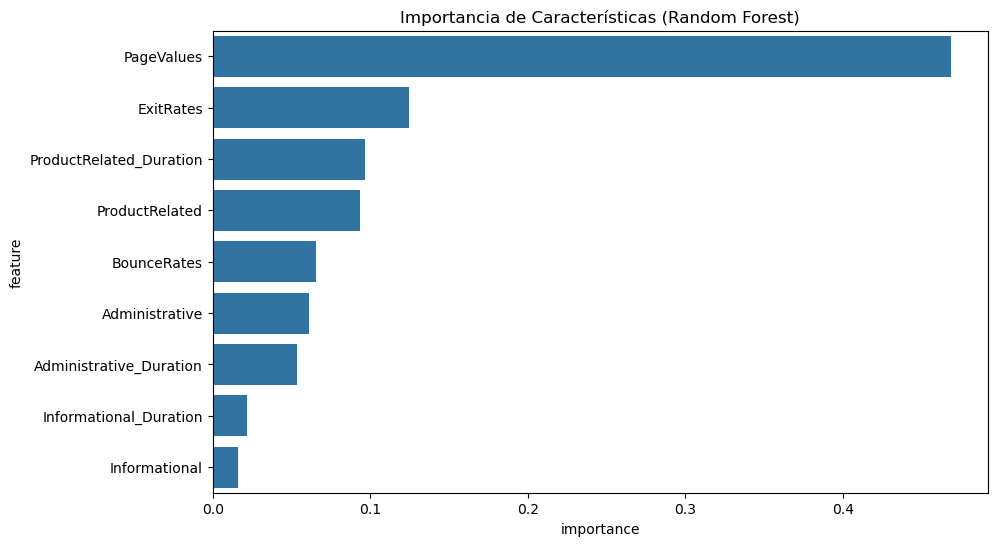

In [12]:
# K-Means (No supervisado)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_resampled)
cluster_labels = kmeans.predict(X_resampled)

# Evaluación del clustering
print("\nK-Means Clustering Evaluation:")
print("Silhouette Score:", silhouette_score(X_resampled, cluster_labels))


# ## 3.3 Análisis de Características


# Importancia de características para Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportancia de características (Random Forest):")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importancia de Características (Random Forest)')
plt.show()


Comparación de medias entre compradores y no compradores:
                         buyers_mean  non_buyers_mean  difference
ProductRelated_Duration  1876.209615      1069.987809  806.221806
Administrative_Duration   119.483244        73.740111   45.743133
Informational_Duration     57.611427        30.236237   27.375189
PageValues                 27.264518         1.975998   25.288520
ProductRelated             48.210168        28.714642   19.495526
Administrative              3.393606         2.117732    1.275874
Informational               0.786164         0.451833    0.334331
BounceRates                 0.005117         0.025317   -0.020200
ExitRates                   0.019555         0.047378   -0.027823


<Figure size 1200x600 with 0 Axes>

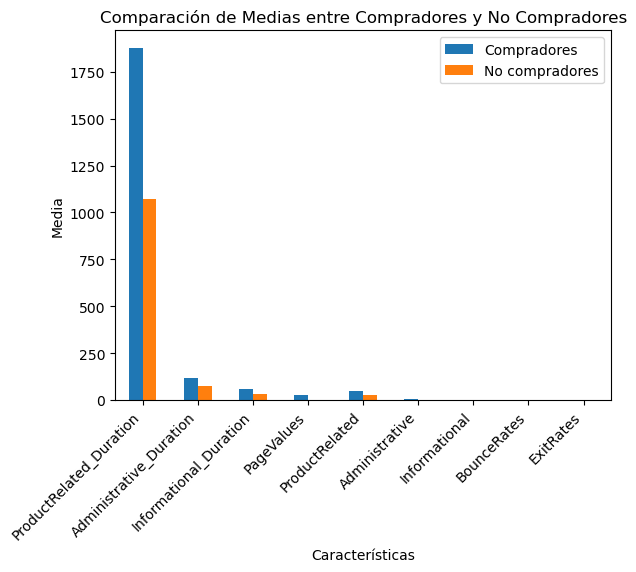

In [13]:
# ## 3.5 Análisis de Segmentos


# Comparación de medias entre compradores y no compradores
buyers = data[data['Revenue'] == 1]
non_buyers = data[data['Revenue'] == 0]

mean_comparison = pd.DataFrame({
    'buyers_mean': buyers[features].mean(),
    'non_buyers_mean': non_buyers[features].mean()
})
mean_comparison['difference'] = mean_comparison['buyers_mean'] - mean_comparison['non_buyers_mean']
mean_comparison = mean_comparison.sort_values('difference', ascending=False)

print("\nComparación de medias entre compradores y no compradores:")
print(mean_comparison)

# Visualización de comparación de medias
plt.figure(figsize=(12, 6))
mean_comparison[['buyers_mean', 'non_buyers_mean']].plot(kind='bar')
plt.title('Comparación de Medias entre Compradores y No Compradores')
plt.xlabel('Características')
plt.ylabel('Media')
plt.xticks(rotation=45, ha='right')
plt.legend(['Compradores', 'No compradores'])



1. **Importancia de características:**
   - La característica más importante para predecir si un visitante realizará una compra es `PageValues`, con una importancia del 40.64%. Esto sugiere que las páginas vistas por un visitante antes de realizar una compra tienen un gran impacto en la probabilidad de conversión.
   - Otras características relevantes incluyen `ExitRates` (12.41%) y `ProductRelated_Duration` (12.34%). Las tasas de salida y la duración de las páginas relacionadas con productos también influyen en la conversión.
   - Por otro lado, características como `Informational` y `Informational_Duration` tienen una importancia relativamente baja.

2. **Comparación de medias entre compradores y no compradores:**
   - Los compradores tienden a pasar más tiempo en páginas relacionadas con productos (`ProductRelated_Duration`) en comparación con los no compradores. La diferencia media es de 806.22 segundos (aproximadamente 13.44 minutos).
   - También hay una diferencia significativa en la duración administrativa (`Administrative_Duration`), donde los compradores pasan más tiempo que los no compradores (diferencia media de 45.74 segundos).
   - La característica `PageValues` muestra una gran diferencia en las medias entre compradores y no compradores (25.29), lo que sugiere que el valor de la página influye en la conversión.
   - Las tasas de rebote (`BounceRates`) y las tasas de salida (`ExitRates`) son más bajas en los compradores en comparación con los no compradores.

3. **Correlación con Revenue:**
   - La característica más positivamente correlacionada con la variable de destino "Revenue" es `PageValues` (0.49). Esto significa que las páginas con un alto valor tienden a estar asociadas con conversiones.
   - Por otro lado, las tasas de rebote (`BounceRates`) y las tasas de salida (`ExitRates`) están negativamente correlacionadas con la conversión. Esto sugiere que los visitantes que permanecen más tiempo en el sitio tienen más probabilidades de convertir.

